In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

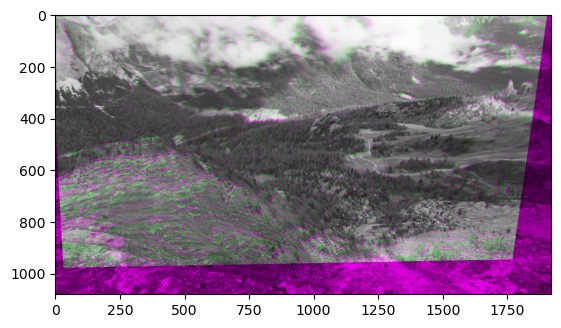

In [2]:
im1_path, im2_path = "input/im2.png", "input/im1.png"

im1 = cv2.cvtColor(cv2.imread(im1_path), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(im2_path), cv2.COLOR_BGR2RGB)


gray1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
sift = cv2.SIFT_create(nfeatures=200)
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# use bf matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
mask = mask.squeeze().astype(bool)

# plot matches
# im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, good_matches, None)
# plt.imshow(im_matches)
# plt.show()

gray_warped = cv2.warpPerspective(gray1, H, (gray2.shape[1], gray2.shape[0]))

# plot warped image
im = np.stack([gray2, gray_warped, gray2], axis=-1)
plt.imshow(im)
plt.show()

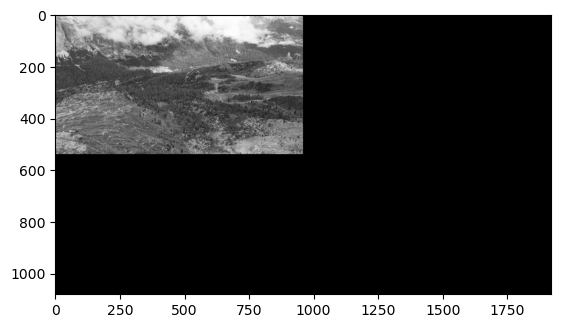

In [128]:
from time import time

class SmoothWarp:
    def __init__(self, im_size, nx=5, ny = 5, w_smooth=0.1, w_rot=0.1):
        self.imx = im_size[1]
        self.imy = im_size[0]
        self.nx = nx
        self.ny = ny
        self.w_smooth = w_smooth
        self.w_rot = w_rot
        self.transforms = np.zeros((ny, nx, 4))
        self.transforms[:, :, 0] = 1
        
    def warp(self, image):
        Nx = 100
        Ny = 100
        dnx = (Nx-3)
        dx = (self.imx-1)
        dny = (Nx-3)
        dy = (self.imy-1)

        x_ = np.linspace(-dx/dnx, dx + dx/dnx, Nx)
        y_ = np.linspace(-dy/dny, dy + dy/dny, Ny)
        
        x_grid, y_grid = np.meshgrid(x_, y_)
        
        wx = x_grid / self.imx * self.nx
        wy = y_grid / self.imy * self.ny

        ix = np.clip(np.floor(wx).astype(int), 0, self.nx-2)
        iy = np.clip(np.floor(wy).astype(int), 0, self.ny-2)

        wx -= ix
        wy -= iy

        w00 = (1 - wx) * (1 - wy)
        w01 = wx * (1 - wy)
        w10 = (1 - wx) * wy
        w11 = wx * wy

        t00 = self.transforms[iy, ix]
        t01 = self.transforms[iy, ix+1]
        t10 = self.transforms[iy+1, ix]
        t11 = self.transforms[iy+1, ix+1]

        coefs = (w00[..., None] * t00 + w01[..., None] * t01 +
                 w10[..., None] * t10 + w11[..., None] * t11)

        pt_in = np.stack([x_grid, y_grid, np.ones_like(x_grid)], axis=-1)
        
        transform = np.zeros((Ny, Nx, 2, 3))
        transform[..., 0, 0] = coefs[..., 0]
        transform[..., 0, 1] = coefs[..., 1]
        transform[..., 0, 2] = coefs[..., 2]
        transform[..., 1, 0] = -coefs[..., 1]
        transform[..., 1, 1] = coefs[..., 0]
        transform[..., 1, 2] = coefs[..., 3]
        
        pts_out = np.einsum('...ij,...j->...i', transform, pt_in)
        
        xs = np.linspace(1, Nx-2, self.imx, dtype = np.float32)
        ys = np.linspace(1, Ny-2, self.imy, dtype = np.float32)
        xx, yy = np.meshgrid(xs, ys)
        coords_out = cv2.remap(pts_out, xx, yy, interpolation=cv2.INTER_LINEAR)
        image_out = cv2.remap(image, coords_out.astype(np.float32), None, cv2.INTER_CUBIC)
        return image_out
    
    def calculate_indices_weights(self, src):
        x = src[:, 0]
        y = src[:, 1]

        wx = x / self.imx * self.nx
        wy = y / self.imy * self.ny

        ix = np.clip(np.floor(wx).astype(int), 0, self.nx-2)
        iy = np.clip(np.floor(wy).astype(int), 0, self.ny-2)

        wx -= ix
        wy -= iy

        w00 = (1 - wx) * (1 - wy)
        w01 = wx * (1 - wy)
        w10 = (1 - wx) * wy
        w11 = wx * wy

        return ix, iy, w00, w01, w10, w11

    def update_hessian(self, ix, iy, a, b, c, d, src_pts, dst_pts):
        N = src_pts.shape[0]
        A = np.zeros((N, 4))
        B = np.zeros((N, 2))

        for i in range(N):
            A[i, :] = [a[i], b[i], c[i], d[i]]
            B[i, :] = dst_pts[i, :] - src_pts[i, :2]

        H = np.zeros((self.ny, self.nx, 4, 4))
        g = np.zeros((self.ny, self.nx, 4, 2))

        for i in range(N):
            H[iy[i], ix[i]] += np.outer(A[i], A[i])
            g[iy[i], ix[i]] += np.outer(A[i], B[i])

        return H, g

    def solve_linear_system(self, H, g):
        for i in range(self.ny):
            for j in range(self.nx):
                H_ij = H[i, j]
                g_ij = g[i, j]
                if np.linalg.cond(H_ij) < 1e10:  # Check if H_ij is well-conditioned
                    self.transforms[i, j] = np.linalg.lstsq(H_ij, g_ij, rcond=None)[0]
                else:
                    self.transforms[i, j] = np.zeros(4)  # Handle ill-conditioned cases

    def estimate_transforms(self, src_pts, dst_pts):
        ix, iy, a, b, c, d = self.calculate_indices_weights(src_pts)
        H, g = self.update_hessian(ix, iy, a, b, c, d, src_pts, dst_pts)
        self.solve_linear_system(H, g)
        
        
    
sw = SmoothWarp(gray2.shape, nx=5, ny=5)
gray_warped_smooth = sw.warp(gray1)
plt.imshow(gray_warped_smooth, cmap='gray')
plt.show()
        

In [71]:


imx = gray2.shape[1]
imy = gray2.shape[0]

nx = 10
ny = 10

x = np.linspace(-nx/imx, imx+ nx/imx, 100)

k = (ny-1)/(imy-1)
k2 = ny/imy
k3 = imy/ny
k4 = ny - 1

y = np.linspace(ny-2, imy - ny + 1, ny)

xx, yy = np.meshgrid(x, y)

coords = np.stack([xx, yy], axis=-1)
coords_out = cv2.resize(coords, (imx, imy), interpolation=cv2.INTER_LINEAR, 

print(coords_out[:3,0,1])
print(coords_out[-3:,0,1])



# coords = cv2.resize(pts_out, (self.imx, self.imy), interpolation=cv2.INTER_CUBIC)

[8. 8. 8.]
[1071. 1071. 1071.]


In [118]:

imx = gray2.shape[1]
imy = gray2.shape[0]

nx = 10
ny = 10

dnx = (nx-3)
dx = (imx-1)
dny = (ny-3)
dy = (imy-1)

x = np.linspace(-dx/dnx, dx + dx/dnx, nx)
y = np.linspace(-dy/dny, dy + dy/dny, ny)

xx, yy = np.meshgrid(x, y)
coords_in = np.stack([xx, yy], axis=-1)


xs = np.linspace(1, nx-2, imx, dtype = np.float32)
ys = np.linspace(1, ny-2, imy, dtype = np.float32)
xx, yy = np.meshgrid(xs, ys)
coords_out = cv2.remap(coords_in, xx, yy, interpolation=cv2.INTER_LINEAR)
print(coords_out[0,0,1],coords_out[-1,0,1])



0.0 1079.0


In [96]:
coords

array([[[-192., -108.],
        [  64., -108.],
        [ 320., -108.],
        [ 576., -108.],
        [ 832., -108.],
        [1088., -108.],
        [1344., -108.],
        [1600., -108.],
        [1856., -108.],
        [2112., -108.]],

       [[-192.,   36.],
        [  64.,   36.],
        [ 320.,   36.],
        [ 576.,   36.],
        [ 832.,   36.],
        [1088.,   36.],
        [1344.,   36.],
        [1600.,   36.],
        [1856.,   36.],
        [2112.,   36.]],

       [[-192.,  180.],
        [  64.,  180.],
        [ 320.,  180.],
        [ 576.,  180.],
        [ 832.,  180.],
        [1088.,  180.],
        [1344.,  180.],
        [1600.,  180.],
        [1856.,  180.],
        [2112.,  180.]],

       [[-192.,  324.],
        [  64.,  324.],
        [ 320.,  324.],
        [ 576.,  324.],
        [ 832.,  324.],
        [1088.,  324.],
        [1344.,  324.],
        [1600.,  324.],
        [1856.,  324.],
        [2112.,  324.]],

       [[-192.,  468.],
        

In [18]:
import numpy as np

def calculate_original_points(target_size, grid_size):
    target_height, target_width = target_size
    original_height, original_width = grid_size
    
    # Calculate scaling factors
    scale_x = (target_width - 1) / (original_width - 1)
    scale_y = (target_height - 1) / (original_height - 1)
    
    # Centers
    x_original_center = (original_width - 1) / 2
    y_original_center = (original_height - 1) / 2
    x_scaled_center = (target_width - 1) / 2
    y_scaled_center = (target_height - 1) / 2
    
    # Original grid points calculation
    x_scaled = np.linspace(0, target_width - 1, target_width)
    y_scaled = np.linspace(0, target_height - 1, target_height)
    
    x_original = (x_scaled - x_scaled_center) / scale_x + x_original_center
    y_original = (y_scaled - y_scaled_center) / scale_y + y_original_center
    
    return x_original, y_original

# Define the target size and original grid size
target_size = (1080, 1920)
grid_size = (100, 100)

x_original, y_original = calculate_original_points(target_size, grid_size)

# Print the first few and last few points to verify
print("Original X coordinates:\n", x_original[:5], "...", x_original[-5:])
print("Original Y coordinates:\n", y_original[:5], "...", y_original[-5:])

Original X coordinates:
 [0.         0.05158937 0.10317874 0.15476811 0.20635748] ... [98.79364252 98.84523189 98.89682126 98.94841063 99.        ]
Original Y coordinates:
 [0.         0.09175162 0.18350324 0.27525487 0.36700649] ... [98.63299351 98.72474513 98.81649676 98.90824838 99.        ]


In [129]:
import sympy as sp

# Define symbolic variables
params = sp.symbols('a00 b00 c00 d00 a01 b01 c01 d01 a10 b10 c10 d10 a11 b11 c11 d11')
w00, w01, w10, w11 = sp.symbols('w00 w01 w10 w11')
src_x, src_y = sp.symbols('src_x src_y')
dst_x, dst_y = sp.symbols('dst_x dst_y')

# Define parameter vectors
a_vec = sp.Matrix([params[0], params[4], params[8], params[12]])
b_vec = sp.Matrix([params[1], params[5], params[9], params[13]])
c_vec = sp.Matrix([params[2], params[6], params[10], params[14]])
d_vec = sp.Matrix([params[3], params[7], params[11], params[15]])

# Define weight vector
w_vec = sp.Matrix([w00, w01, w10, w11])

# Compute bilinear combination
a = (a_vec.T * w_vec)[0]
b = (b_vec.T * w_vec)[0]
c = (c_vec.T * w_vec)[0]
d = (d_vec.T * w_vec)[0]

# Define the transformation
transformed = sp.Matrix([
    a * src_x + b * src_y + c,
    -b * src_x + a * src_y + d
])

# Define the destination vector
dst = sp.Matrix([dst_x, dst_y])

# Define the loss function
loss = sp.sum((transformed - dst)**2)

# Calculate gradients
gradients = sp.Matrix([sp.diff(loss, p) for p in params])

# Print gradients
param_names = ['a00', 'b00', 'c00', 'd00', 'a01', 'b01', 'c01', 'd01', 'a10', 'b10', 'c10', 'd10', 'a11', 'b11', 'c11', 'd11']
for param, grad in zip(param_names, gradients):
    print(f"Gradient with respect to {param}: {grad}")

AttributeError: module 'sympy' has no attribute 'sum'

In [130]:
(transformed - dst)**2

NonSquareMatrixError: 